In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
from datetime import date
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import gc

In [2]:
def category_crosstab(category, target, dataframe):
    df = pd.crosstab(dataframe[target], dataframe[category], normalize='columns').transpose().sort_values(by=0, ascending=False)
    
    return df

def kmeans_clusterer(category, target, dataframe, validation_dataframe, k_clusters = 0, colors = 'rainbow'):
    import matplotlib.pyplot as plt
    from kneed import KneeLocator
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    
    columns= [category, target]
    cluster_data = dataframe[columns]
    
    conditional_probability = category_crosstab(category, target, cluster_data)
    cluster_data['conditional_probability'] = cluster_data[category].apply(lambda x: conditional_probability.loc[x][1])
    
    cluster_data['Income_count']=cluster_data['Income'].copy()
    
    clustering_data = cluster_data.groupby(category).agg({'Income':'sum',
                                                          'Income_count':'count',
                                                          'conditional_probability':'first'}).sort_values(by='Income_count')
    clustering_data
    
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)

    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1500,
    "random_state": 42,
        }

    # A list holds the SSE values for each k
    sse = []
    
    number_unique_categories = len(dataframe[category].unique())
    if number_unique_categories > 10: 
        max_number_clusters = 11
    else:
        max_number_clusters = number_unique_categories

    for k in range(1, max_number_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    
  
    # Define Elbow point

    kl = KneeLocator(range(1, max_number_clusters), 
                     sse, 
                     curve="convex", 
                     direction="decreasing")
    
    if k_clusters == 0 : 
        number_cluster = kl.elbow
    else: 
        number_cluster = k_clusters
    
    # Run k means 
    
    kmeans= KMeans(n_clusters=number_cluster, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    
    # assign kmeans labels to each category
    clustering_data['kmeans_cluster'] = kmeans.labels_
    
    
    # plot SSE (inertia) vs number of clusters - Improve
    plt.style.use('dark_background')
    plt.style.use('dark_background')
    fig, axes = plt.subplots(3,1,figsize=(10,20))
    fig.suptitle(category, fontsize=16)
    
        # first plot - inertia vs number of clusters
        
    x = range(1, max_number_clusters)
    y = sse
    #plt.style.use("fivethirtyeight")
    axes[0].plot(x, sse, marker = "D" )
    plt.sca(axes[0])
    plt.set_cmap(colors)
    plt.title('Inertia vs Number of Clusters')
    plt.xticks(range(1, max_number_clusters))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.plot(x[number_cluster -1], y[number_cluster -1], 'ro')
    
        # second plot - number of individuals in class vs conditional probability
    
    sns.scatterplot(x='Income_count', 
                    y='conditional_probability', 
                    hue = 'kmeans_cluster' , 
                    data = clustering_data,
                    palette = colors,
                    ax = axes[1])
    
    plt.sca(axes[1])
    plt.title('Number of individuals in Category vs Conditional Probability')
    #plt.xticks(range(0, 100))
    # Set x-axis label
    plt.xlabel('Number of individuals in Category')
    # Set y-axis label
    plt.ylabel('Conditional Probability')
    
        # third plot - number of individuals in class that hit target vs conditional probability

    sns.scatterplot(x='Income', 
                    y='conditional_probability', 
                    hue = 'kmeans_cluster' , 
                    data = clustering_data,
                    palette = colors,
                    ax = axes[2])
    
    plt.sca(axes[2])
    plt.title('Number of individuals in Category w/ Target vs Conditional Probability')
    #plt.xticks(range(0, 100))
    # Set x-axis label
    plt.xlabel('Number of individuals in Category')
    # Set y-axis label
    plt.ylabel('Conditional Probability')
    
    #3d plotting 
    
    fig = plt.figure()
    fig.suptitle(category, fontsize=16)
    ax = plt.axes(projection='3d')
    
    # Data for three-dimensional scattered points
    zdata = clustering_data['conditional_probability']
    xdata = clustering_data['Income']
    ydata = clustering_data['Income_count']
    ax.scatter3D(xdata, ydata, zdata, c=clustering_data['kmeans_cluster'])#, cmap=colors);
    ax.set_xlabel('People in Category')
    ax.set_ylabel('People in Category w/target')
    ax.set_zlabel('Conditional Probability');
    
    
    display(clustering_data.sort_values(by='kmeans_cluster'))
    # Add cluster as dimension 
    new_category= category +' - Clustered'
    dataframe[new_category] = dataframe[category].apply(lambda x: clustering_data['kmeans_cluster'][x])
    validation_dataframe[new_category] = validation_dataframe[category].apply(lambda x: clustering_data['kmeans_cluster'][x])
    

    print('Process done')
    return kmeans

In [3]:
def simple_kmeans(clustering_data, max_k =10, k_clusters = 'else', visualize = True):
    import matplotlib.pyplot as plt
    from kneed import KneeLocator
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import StandardScaler

    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_data)
    scaled_df = pd.DataFrame(scaled_features)
    scaled_df.columns = clustering_data.columns

    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1500,
    "random_state": 42,
        }

    # A list holds the SSE values for each k
    sse = []
    
    # Measuring SSE for different k cluster levels
    max_number_clusters = max_k
    
    
    for k in range(1, max_number_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
        
        # Define Elbow point Automatically or manually. 

    kl = KneeLocator(range(1, max_number_clusters), 
                     sse, 
                     curve="convex", 
                     direction="decreasing")
    
    
    if k_clusters == 'else' : 
        number_cluster = kl.elbow
    else: 
        number_cluster = k_clusters
    
    if visualize == True:
    
        # plot SSE (inertia) vs number of clusters - Improve

        plt.style.use('fivethirtyeight') # set dark style, 'cause its simply better. 
        #plt.set_cmap('Set1')

        fig, axes = plt.subplots(1,1,figsize=(10,20)) #3 subplots, each with its row
        #fig.suptitle(category, fontsize=16)

            # first plot - inertia vs number of clusters

        x = range(1, max_number_clusters)
        y = sse
        #plt.style.use("fivethirtyeight")
        axes.plot(x, sse )

        plt.sca(axes) # select ax0 
        #plt.set_cmap(colors)

        plt.title('Inertia vs Number of Clusters') #title
        plt.xticks(range(1, max_number_clusters)) # xticks
        plt.xlabel("Number of Clusters") # xlabels
        plt.ylabel("SSE") # ylabels
        plt.plot(x[number_cluster -1], y[number_cluster -1], color='green', marker='X', 
                 linestyle='dashed', linewidth=15, markersize=25) # show that represents 

    
    
    # Run k means with right number of clusters 
    
    kmeans= KMeans(n_clusters=number_cluster, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    
    # assign kmeans labels to each category
    clustering_data['kmeans_cluster'] = kmeans.labels_
    scaled_df['kmeans_cluster'] = kmeans.labels_
    
    display(clustering_data.sort_values(by='kmeans_cluster'))
    
    return scaled_df

def boxplot_cluster_compparisson(dataframe):

    variables = dataframe.iloc[:,:-1].columns
    number_variables = len(variables)
    height = number_variables*20

    fig, ax = plt.subplots(number_variables,1, figsize =(height,height))

    for variable, x in zip(variables, range(number_variables)): 
        sns.boxplot(x= dataframe.iloc[:,-1] ,
                    y = dataframe[variable],
                       ax = ax[x])     
    return fig

def kmeans_analysis(clustering_data, max_k =10, k_clusters = 'else', visualize = True):
    
    sc_df = simple_kmeans(clustering_data, max_k =10, k_clusters = 'else', visualize = True)
    graphs = boxplot_cluster_compparisson(sc_df)
    return graphs, sc_df

In [4]:
def plot_cumulative_significance_PCA(pca, plotTitle):
    """Takes the PCA model after fit and transform, plotting the cumulative significance of each component"""

    # figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # draw plots
    ax1.plot(pca.explained_variance_, marker=".", markersize=12)
    ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

    # customizations
    ax2.legend()
    ax1.set_title(plotTitle, fontsize=14)
    ax2.set_title("Variance Explained", fontsize=14)
    ax1.set_ylabel("Eigenvalue")
    ax2.set_ylabel("Proportion")
    ax1.set_xlabel("Components")
    ax2.set_xlabel("Components")
    ax1.set_xticks(range(0, pca.n_components_, 2))
    ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
    ax2.set_xticks(range(0, pca.n_components_, 2))
    ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

    plt.show()

In [5]:
def pca_analysis(subgroups_pca_dic, path_to_excel):
   # writer = pd.ExcelWriter('/Files/test_pca.xlsx')

    for subGroup in hood_subgroups_pca_dic.keys():
        columns = hood_subgroups_dic[subGroup]
        k = hood_subgroups_pca_dic[subGroup]

        #PCA fit
        pca = PCA(n_components=k)
        pca_feat = pca.fit_transform(pca_data[columns])

        #Creating dataframe
        pca_feat_names = [f"PC{i}" for i in range(k)]
        pca_df = pd.DataFrame(pca_feat, index=pca_data[columns].index, columns=pca_feat_names)

        # Reassigning df to contain pca variables
        pca_df = pd.concat([pca_data[columns], pca_df], axis=1)

        # Interpreting each Principal Component
        loadings = pca_df[columns + pca_feat_names].corr().loc[columns, pca_feat_names]
        print("\n\n\n//////////////////////////////////%s" % subGroup)
        display(loadings.style.applymap(_color_red_or_green))

        # Returning an excel file (sorry) with the analysis

        test='home_structures'

        loadings.style.applymap(_color_red_or_green).to_excel(writer, subGroup)
        #writer.save()

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

# 0. Loading our Data

In [7]:
df = pd.read_csv('Data/donors.csv')
df = df.drop(columns=['Unnamed: 0'])

C:\Users\ivkis\anaconda3\envs\DM\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (9,412) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,,,,XXXX,T2,,,,,,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0,39,34,18,10,2,1,,,,5.0,,,,,,,,,,,,,,,,,,,,,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,2017-06-01,2016-06-01,2016-04-01,2016-04-01,2016-03-01,2016-02-01,20

In [9]:
df.info('all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 475 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ODATEDW   object 
 1   OSOURCE   object 
 2   TCODE     int64  
 3   STATE     object 
 4   ZIP       object 
 5   MAILCODE  object 
 6   PVASTATE  object 
 7   DOB       object 
 8   NOEXCH    object 
 9   RECINHSE  object 
 10  RECP3     object 
 11  RECPGVG   object 
 12  RECSWEEP  object 
 13  MDMAUD    object 
 14  DOMAIN    object 
 15  HOMEOWNR  object 
 16  CHILD03   object 
 17  CHILD07   object 
 18  CHILD12   object 
 19  CHILD18   object 
 20  NUMCHLD   float64
 21  INCOME    float64
 22  GENDER    object 
 23  WEALTH1   float64
 24  HIT       int64  
 25  MBCRAFT   float64
 26  MBGARDEN  float64
 27  MBBOOKS   float64
 28  MBCOLECT  float64
 29  MAGFAML   float64
 30  MAGFEM    float64
 31  MAGMALE   float64
 32  PUBGARDN  float64
 33  PUBCULIN  float64
 34  PUBHLTH   float64
 35  PUBDOITY  float64
 36  PUBNEWFN  f

# 1.Analysing Data

We analyse data in blocks of columns for each dimension, one by one 

## 1.1. Befaviour dimension

## Date columns
ADATE and RDATE

## Lags between ADATE and RDATE

In [10]:
df_ = df.copy()
lag_cols = ['LAG_%s' % i for i in range(3,25)]

# lags in days
for i in range(3,25):
    df_['LAG_%s' % i] = (pd.to_datetime(df_['RDATE_%s' % i]) -
                         pd.to_datetime(df_['ADATE_%s' % i])) / np.timedelta64(1, 'D')
    
df_['LAG_avg'] = df_[lag_cols].mean(axis=1)
df_['LAG_variance'] = df_[lag_cols].var(axis=1)
df_['LAG_min'] = df_[lag_cols].min(axis=1)
df_['LAG_max'] = df_[lag_cols].max(axis=1)
df_[['LAG_avg', 'LAG_variance', 'LAG_min', 'LAG_max']]

,LAG_avg,LAG_variance,LAG_min,LAG_max
0,34.428571,448.285714,0.0,61.0
1,30.500000,0.500000,30.0,31.0
2,8.857143,228.809524,0.0,31.0
3,39.000000,537.000000,0.0,61.0
4,0.000000,0.000000,0.0,0.0
...,...,...,...,...
95407,31.000000,NaN,31.0,31.0
95408,60.000000,NaN,60.0,60.0
95409,22.750000,850.250000,0.0,61.0
95410,47.555556,1665.027778,-31.0,92.0


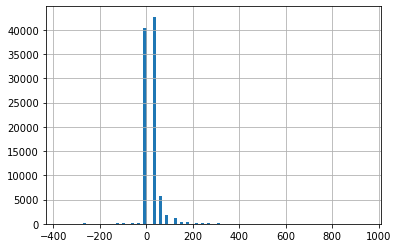

In [11]:
df_['LAG_min'].hist(bins=100);
# negatives are anomalies

negatives are anomalies, we must delete them

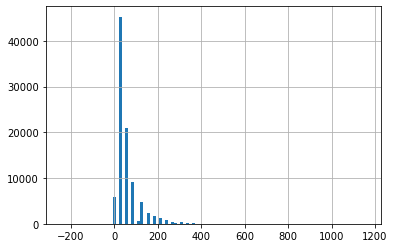

In [12]:
df_['LAG_max'].hist(bins=100);

**Treatment of negative lags (ADATE > RDATE)**  


In [13]:
df_ = df.copy()
lag_cols = ['LAG_%s' % i for i in range(3,25)]
rdate_cols = ['RDATE_%s' % i for i in range(3,25)]
adate_cols = ['ADATE_%s' % i for i in range(3,25)]

# let's replace RDATEs that are before ADATEs with NaNs
# Replace NaNs
df_[rdate_cols] = df_[rdate_cols].fillna('1900-01-01')
df_[adate_cols] = df_[adate_cols].fillna('1901-01-01') # NaN < NaN -> NaN

# Turn errors back to NaNs
for i in range(3,25):
    df_['RDATE_%s' % i] = df_[['RDATE_%s' % i,'ADATE_%s' % i]] \
                             .apply(lambda row: np.nan if row['RDATE_%s' % i] < row['ADATE_%s' % i]
                                    else row['RDATE_%s' % i], axis=1)
df_[adate_cols] = np.where(df_[adate_cols]=='1901-01-01', np.NaN, df_[adate_cols])
    
# lags in days
for i in range(3,25):
    df_['LAG_%s' % i] = (pd.to_datetime(df_['RDATE_%s' % i]) -
                         pd.to_datetime(df_['ADATE_%s' % i])) / np.timedelta64(1, 'D')
    
df_['LAG_avg'] = df_[lag_cols].mean(axis=1)
df_['LAG_variance'] = df_[lag_cols].var(axis=1)
df_['LAG_min'] = df_[lag_cols].min(axis=1)
df_['LAG_max'] = df_[lag_cols].max(axis=1)
df_[['LAG_avg', 'LAG_variance', 'LAG_min', 'LAG_max']]

,LAG_avg,LAG_variance,LAG_min,LAG_max
0,34.428571,448.285714,0.0,61.0
1,30.500000,0.500000,30.0,31.0
2,8.857143,228.809524,0.0,31.0
3,39.000000,537.000000,0.0,61.0
4,0.000000,0.000000,0.0,0.0
...,...,...,...,...
95407,31.000000,NaN,31.0,31.0
95408,60.000000,NaN,60.0,60.0
95409,22.750000,850.250000,0.0,61.0
95410,57.375000,911.125000,30.0,92.0


In [14]:
df_['LAG_min'].min()
# no more negatives

0.0

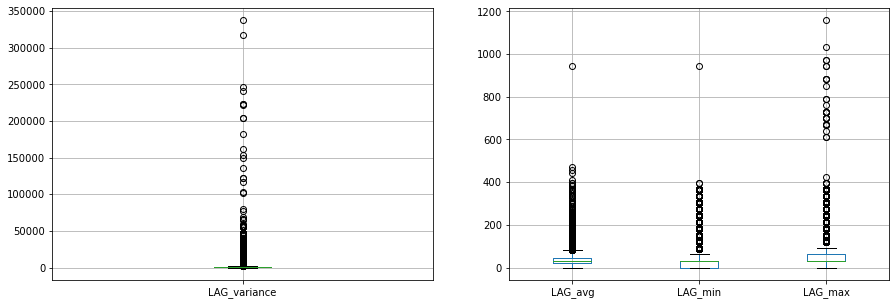

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_[['LAG_variance']].boxplot(ax=axes[0])
df_[['LAG_avg','LAG_min','LAG_max']].boxplot()
plt.show()

### Scaling

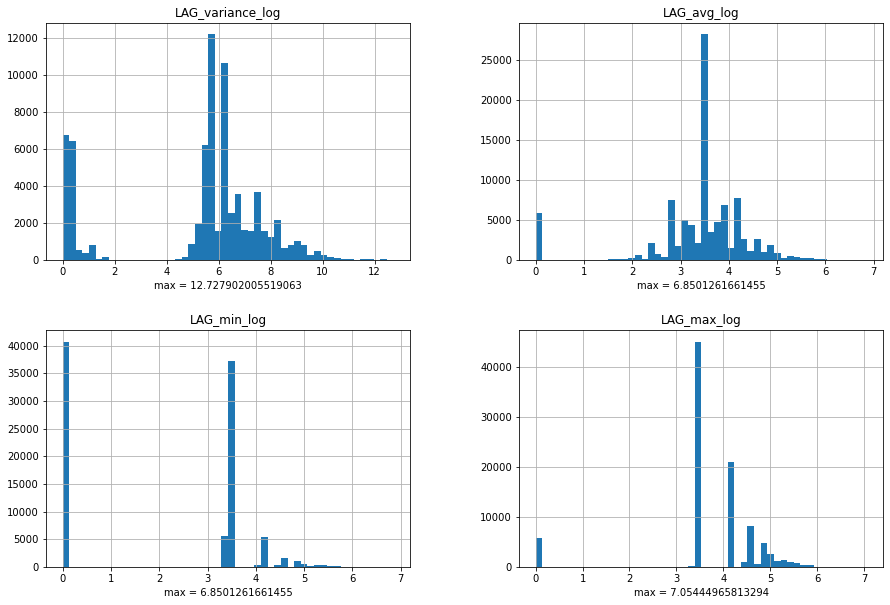

In [16]:
# log-scale them
df_['LAG_variance_log'] = df_['LAG_variance'].apply(lambda x: np.log(x+1))
df_['LAG_avg_log'] = df_['LAG_avg'].apply(lambda x: np.log(x+1))
df_['LAG_min_log'] = df_['LAG_min'].apply(lambda x: np.log(x+1))
df_['LAG_max_log'] = df_['LAG_max'].apply(lambda x: np.log(x+1))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
df_[['LAG_variance_log']].hist(bins=50, ax=axes[0, 0])
df_[['LAG_avg_log']].hist(bins=50, ax=axes[0, 1])
df_[['LAG_min_log']].hist(bins=50, ax=axes[1, 0])
df_[['LAG_max_log']].hist(bins=50, ax=axes[1, 1])
axes[0, 0].set_xlabel('max = {}'.format(df_['LAG_variance_log'].max()))
axes[0, 1].set_xlabel('max = {}'.format(df_['LAG_avg_log'].max()))
axes[1, 0].set_xlabel('max = {}'.format(df_['LAG_min_log'].max()))
axes[1, 1].set_xlabel('max = {}'.format(df_['LAG_max_log'].max()))
plt.show()

In [17]:
# Min-Max scaling
df_['LAG_avg_log'] = MinMaxScaler().fit_transform(df_[['LAG_avg_log']])
df_['LAG_variance_log'] = MinMaxScaler().fit_transform(df_[['LAG_variance_log']])
df_['LAG_min_log'] = MinMaxScaler().fit_transform(df_[['LAG_min_log']])
df_['LAG_max_log'] = MinMaxScaler().fit_transform(df_[['LAG_max_log']])

In [18]:
df_lags = df_[['LAG_avg_log', 'LAG_variance_log', 'LAG_min_log', 'LAG_max_log']].copy()
df_lags

,LAG_avg_log,LAG_variance_log,LAG_min_log,LAG_max_log
0,0.520796,0.479864,0.000000,0.585040
1,0.503639,0.031856,0.501303,0.491284
2,0.334037,0.427191,0.000000,0.491284
3,0.538513,0.494022,0.000000,0.585040
4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
95407,0.505938,NaN,0.505938,0.491284
95408,0.600117,NaN,0.600117,0.582735
95409,0.462412,0.530072,0.000000,0.585040
95410,0.593695,0.535499,0.501303,0.642516


## RFA columns

*According to metadata:*    
**RECENCY:** F, N, A, L, I, S  

**FREQUENCY:** 1, 2, 3, 4 (=4+)  
The period of recency for all groups except L and I is the last 12 months.  
For L it is 13-24 months ago, and for I it is 25-36 months ago.  
   
**AMOUNT $:**  
A(0.01-1.99) B(2.00-2.99) C(3.00-4.99) D(5.00-9.99)  
E(10.00-14.99) F(15.00-24.99) G(25.00+)  

In [19]:
re_expression = re.compile('^RFA_\d{1,2}$')
rfa_columns = [column for column in df.columns.values if re_expression.match(column)]

df_rfa = df[rfa_columns]
df_rfa.head()

,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24
0,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E
1,L2G,A2G,A2G,A2G,A2G,A1E,A1E,A1E,A1E,A1E,A1E,,,,L1E,,,N1E,N1E,N1E,N1E,,F1E
2,L4E,S4E,S4E,S4E,S4E,S4F,S4F,S4F,,S4F,S4F,S4F,S4F,S4F,S4F,,S4D,S4D,,,S4D,S4D,S3D
3,L4E,S4E,S4E,S4E,S4E,S4E,S4E,S4E,,S4E,S4E,S4E,S4E,S4E,S4E,S2D,S2D,A1D,A1D,A1D,A1D,,
4,L2F,A2F,A2F,A2F,A1D,I2D,A1E,A1E,L1D,A1E,A1E,L1D,L3D,,L3D,A2D,A2D,A3D,A3D,A3D,I4E,A3D,A3D


In [20]:
rfa_all = df_rfa.values.tolist()

# unique codes
rfa_all = set([val for col in rfa_all for val in col])

# unique values for 1st byte
rfa_R = set([val[0] for val in rfa_all])

In [21]:
# possible lengths of codes
rfa_all_length = set([len(val) for val in rfa_all])
rfa_all_length

{1, 2, 3}

In [22]:
print(sorted(rfa_all))

[' ', '1C', '1D', '1E', '1F', '1G', '2D', '2E', '2F', '3E', '3F', '4E', 'A1A', 'A1B', 'A1C', 'A1D', 'A1E', 'A1F', 'A1G', 'A2B', 'A2C', 'A2D', 'A2E', 'A2F', 'A2G', 'A3B', 'A3C', 'A3D', 'A3E', 'A3F', 'A3G', 'A4A', 'A4B', 'A4C', 'A4D', 'A4E', 'A4F', 'A4G', 'F1A', 'F1B', 'F1C', 'F1D', 'F1E', 'F1F', 'F1G', 'I1B', 'I1C', 'I1D', 'I1E', 'I1F', 'I1G', 'I2C', 'I2D', 'I2E', 'I2F', 'I2G', 'I3C', 'I3D', 'I3E', 'I3F', 'I3G', 'I4C', 'I4D', 'I4E', 'I4F', 'I4G', 'L1C', 'L1D', 'L1E', 'L1F', 'L1G', 'L2C', 'L2D', 'L2E', 'L2F', 'L2G', 'L3C', 'L3D', 'L3E', 'L3F', 'L3G', 'L4C', 'L4D', 'L4E', 'L4F', 'L4G', 'N1B', 'N1C', 'N1D', 'N1E', 'N1F', 'N1G', 'N2A', 'N2B', 'N2C', 'N2D', 'N2E', 'N2F', 'N2G', 'N3B', 'N3C', 'N3D', 'N3E', 'N3F', 'N3G', 'N4C', 'N4D', 'N4E', 'N4F', 'N4G', 'P1A', 'P1B', 'P1C', 'P1D', 'P1E', 'P1F', 'P1G', 'S2A', 'S2B', 'S2C', 'S2D', 'S2E', 'S2F', 'S2G', 'S3A', 'S3B', 'S3C', 'S3D', 'S3E', 'S3F', 'S3G', 'S4A', 'S4B', 'S4C', 'S4D', 'S4E', 'S4F', 'S4G', 'U1C', 'U1D', 'U1E', 'U1F', 'U1G']


Let's explore anomalies in 1st byte

In [23]:
sorted(rfa_R)

[' ', '1', '2', '3', '4', 'A', 'F', 'I', 'L', 'N', 'P', 'S', 'U']

**Anomalies:**  
1) Empty 1st byte = empty cell  
2) Digits in 1st byte = cells starting from 2nd byte of RFA code  
3) 'P' -- unknown recency code, possible handwriting error for F   
4) 'U' -- unknow recency code, possibly stands for Unknown  

**(2) Digits**

In [24]:
# Seeking the columns containing digits at 1st place
for val in ['1', '2', '3', '4']:
    print('----')
    print(val)
    for i in range(df_rfa.shape[1]):
        ser = df_rfa[df_rfa.iloc[:,i].str.startswith(val)].iloc[:,i].head()
        if len(ser) > 0:
            display(ser)

----
1


13722    1D
25868    1E
27515    1D
32696    1C
41932    1G
Name: RFA_23, dtype: object

----
2


7469     2F
21445    2D
28873    2F
32397    2F
48720    2E
Name: RFA_23, dtype: object

----
3


18855    3E
48354    3E
65151    3F
82070    3E
Name: RFA_23, dtype: object

----
4


61927    4E
Name: RFA_23, dtype: object

**Starting from numbers:** only RFA_23  
promo FS : blank cards that fold into thirds with labels  
year 2014  

Let's treat it

In [25]:
# 'U' for 'unknown'
df_rfa['RFA_23'] = df_rfa['RFA_23'].apply(lambda x: x.replace(x, 'U'+x) if x[0] in ['1','2','3','4'] else x)

# unique Recency codes now
set([val[0] for col in df_rfa.values.tolist() for val in col])

<ipython-input-25-b0a104ab2293>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfa['RFA_23'] = df_rfa['RFA_23'].apply(lambda x: x.replace(x, 'U'+x) if x[0] in ['1','2','3','4'] else x)


{' ', 'A', 'F', 'I', 'L', 'N', 'P', 'S', 'U'}

**(3) 'P', 'U'**

In [26]:
[code for code in list(rfa_all) if code[0]=='P']

['P1C', 'P1D', 'P1A', 'P1E', 'P1B', 'P1F', 'P1G']

In [27]:
[code for code in list(rfa_all) if code[0]=='U']

['U1E', 'U1D', 'U1F', 'U1G', 'U1C']

all above have frequency 1

In [28]:
print('P:')
for i in range(23):
        print('---')
        display(df_rfa[df_rfa.iloc[:,i].str.startswith('P')].iloc[:,i].head())
print('=========')
print('U:')
for i in range(23):
        print('---')
        display(df_rfa[df_rfa.iloc[:,i].str.startswith('U')].iloc[:,i].head())

P:
---


Series([], Name: RFA_2, dtype: object)

---


Series([], Name: RFA_3, dtype: object)

---


Series([], Name: RFA_4, dtype: object)

---


Series([], Name: RFA_5, dtype: object)

---


2879     P1F
18792    P1G
35458    P1F
45960    P1A
Name: RFA_6, dtype: object

---


10    P1F
60    P1F
68    P1G
88    P1G
99    P1F
Name: RFA_7, dtype: object

---


10    P1F
60    P1F
68    P1G
88    P1G
99    P1F
Name: RFA_8, dtype: object

---


90     P1G
196    P1G
281    P1F
411    P1F
528    P1F
Name: RFA_9, dtype: object

---


Series([], Name: RFA_10, dtype: object)

---


11     P1F
21     P1G
26     P1G
83     P1F
167    P1F
Name: RFA_11, dtype: object

---


11     P1F
21     P1G
26     P1G
83     P1F
125    P1G
Name: RFA_12, dtype: object

---


Series([], Name: RFA_13, dtype: object)

---


31     P1F
36     P1G
61     P1F
64     P1F
117    P1D
Name: RFA_14, dtype: object

---


Series([], Name: RFA_15, dtype: object)

---


20025    P1D
45170    P1E
78571    P1C
81760    P1D
85184    P1E
Name: RFA_16, dtype: object

---


32    P1F
42    P1E
49    P1A
65    P1E
72    P1F
Name: RFA_17, dtype: object

---


32    P1F
35    P1E
42    P1E
49    P1F
65    P1E
Name: RFA_18, dtype: object

---


92     P1C
128    P1D
170    P1E
184    P1D
215    P1E
Name: RFA_19, dtype: object

---


Series([], Name: RFA_20, dtype: object)

---


19     P1F
24     P1D
56     P1E
76     P1G
105    P1F
Name: RFA_21, dtype: object

---


19    P1F
24    P1D
56    P1E
76    P1G
82    P1D
Name: RFA_22, dtype: object

---


Series([], Name: RFA_23, dtype: object)

---


172    P1C
372    P1C
387    P1A
686    P1F
713    P1D
Name: RFA_24, dtype: object

U:
---


Series([], Name: RFA_2, dtype: object)

---


Series([], Name: RFA_3, dtype: object)

---


Series([], Name: RFA_4, dtype: object)

---


Series([], Name: RFA_5, dtype: object)

---


3931    U1E
4068    U1F
5165    U1E
5306    U1F
6602    U1F
Name: RFA_6, dtype: object

---


26928    U1G
Name: RFA_7, dtype: object

---


1599     U1F
3601     U1E
7282     U1G
8896     U1F
20273    U1F
Name: RFA_8, dtype: object

---


17       U1G
1553     U1F
3807     U1F
29889    U1G
52656    U1G
Name: RFA_9, dtype: object

---


Series([], Name: RFA_10, dtype: object)

---


Series([], Name: RFA_11, dtype: object)

---


303     U1F
571     U1F
818     U1F
1720    U1G
1733    U1D
Name: RFA_12, dtype: object

---


13635    U1G
23224    U1E
30808    U1D
67170    U1E
79298    U1E
Name: RFA_13, dtype: object

---


1415     U1D
20040    U1E
23224    U1E
42668    U1E
49536    U1E
Name: RFA_14, dtype: object

---


30810    U1F
Name: RFA_15, dtype: object

---


69      U1G
1002    U1D
1168    U1F
1249    U1F
1384    U1E
Name: RFA_16, dtype: object

---


1486    U1F
1780    U1D
3881    U1E
6224    U1F
6613    U1F
Name: RFA_17, dtype: object

---


25     U1F
667    U1E
749    U1E
818    U1D
876    U1F
Name: RFA_18, dtype: object

---


203     U1F
1198    U1E
1567    U1D
2655    U1E
2773    U1D
Name: RFA_19, dtype: object

---


14219    U1E
59828    U1E
78289    U1D
Name: RFA_20, dtype: object

---


Series([], Name: RFA_21, dtype: object)

---


644     U1E
3006    U1E
3531    U1E
5788    U1G
6149    U1E
Name: RFA_22, dtype: object

---


7469     U2F
13722    U1D
18855    U3E
20192    U1D
21445    U2D
Name: RFA_23, dtype: object

---


1551     U1E
2307     U1D
2927     U1F
7094     U1E
20192    U1D
Name: RFA_24, dtype: object

In [29]:
# Let's keep U for unknown and also replace P with U
df_rfa = df_rfa.applymap(lambda x: x.replace('P', 'U'))

# Replace empty with all unknown
df_rfa = df_rfa.applymap(lambda x: x.replace(' ', 'UUU')).fillna('UUU')

# unique RFA codes now
rfa_all = sorted(set([val for col in df_rfa.values.tolist() for val in col]))
print(rfa_all)

['A1A', 'A1B', 'A1C', 'A1D', 'A1E', 'A1F', 'A1G', 'A2B', 'A2C', 'A2D', 'A2E', 'A2F', 'A2G', 'A3B', 'A3C', 'A3D', 'A3E', 'A3F', 'A3G', 'A4A', 'A4B', 'A4C', 'A4D', 'A4E', 'A4F', 'A4G', 'F1A', 'F1B', 'F1C', 'F1D', 'F1E', 'F1F', 'F1G', 'I1B', 'I1C', 'I1D', 'I1E', 'I1F', 'I1G', 'I2C', 'I2D', 'I2E', 'I2F', 'I2G', 'I3C', 'I3D', 'I3E', 'I3F', 'I3G', 'I4C', 'I4D', 'I4E', 'I4F', 'I4G', 'L1C', 'L1D', 'L1E', 'L1F', 'L1G', 'L2C', 'L2D', 'L2E', 'L2F', 'L2G', 'L3C', 'L3D', 'L3E', 'L3F', 'L3G', 'L4C', 'L4D', 'L4E', 'L4F', 'L4G', 'N1B', 'N1C', 'N1D', 'N1E', 'N1F', 'N1G', 'N2A', 'N2B', 'N2C', 'N2D', 'N2E', 'N2F', 'N2G', 'N3B', 'N3C', 'N3D', 'N3E', 'N3F', 'N3G', 'N4C', 'N4D', 'N4E', 'N4F', 'N4G', 'S2A', 'S2B', 'S2C', 'S2D', 'S2E', 'S2F', 'S2G', 'S3A', 'S3B', 'S3C', 'S3D', 'S3E', 'S3F', 'S3G', 'S4A', 'S4B', 'S4C', 'S4D', 'S4E', 'S4F', 'S4G', 'U1A', 'U1B', 'U1C', 'U1D', 'U1E', 'U1F', 'U1G', 'U2D', 'U2E', 'U2F', 'U3E', 'U3F', 'U4E', 'UUU']


In [30]:
rfa_F = set([val[-2] for val in rfa_all])
rfa_A = set([val[-1] for val in rfa_all])
print(sorted(rfa_F))
print(sorted(rfa_A))

['1', '2', '3', '4', 'U']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']


For first-time-donor statuses (F) let's count RDATEs that are **before** given promotion date ADATE

In [31]:
startwith = 'F'
      
for j in range(3, 25):
# loop through promotions 

    # RDATEs except RDATE_j
    rdate_cols = ['RDATE_%s' % i for i in range(3, 25)] 
    
    # filtered dataframe - only First-time donors for promo j
    df_ = df[df['RFA_%s' % j].str.startswith(startwith)][['RFA_%s' % j] + ['ADATE_%s' % j] + rdate_cols]
    df_[rdate_cols] = df_[rdate_cols].fillna('2200-01-01')
    
    # we replace with '1' those RDATEs that are earlier than given ADATE
    for col in rdate_cols:
        df_[col] = df_.apply(lambda row: 1 if row[col]<row['ADATE_%s' % j] else 0, axis=1)
        
    df_['gifts_before'] = df_[rdate_cols].apply(lambda row: row.sum(), axis=1)
    df_ = df_.drop(columns=rdate_cols)
    
    print('---')
    print('rows starting with {} for promo_{}:'.format(startwith, j), len(df_))
    print(df_['gifts_before'].value_counts())

---
rows starting with F for promo_3: 8316
1     7757
0      226
2      190
3       52
4       31
6       18
5       18
7        8
9        6
8        6
10       2
12       1
11       1
Name: gifts_before, dtype: int64
---
rows starting with F for promo_4: 8361
1     7757
0      230
2      199
3       76
4       38
5       21
6       19
7        7
8        6
9        3
10       2
14       1
12       1
11       1
Name: gifts_before, dtype: int64
---
rows starting with F for promo_5: 0
Series([], Name: gifts_before, dtype: int64)
---
rows starting with F for promo_6: 10037
1     8512
2      790
0      543
3       80
4       39
6       22
5       20
8       15
7       10
9        3
10       2
11       1
Name: gifts_before, dtype: int64
---
rows starting with F for promo_7: 7135
1     5427
2     1003
0      387
3      226
4       38
6       19
5       17
7        8
8        4
9        3
10       2
11       1
Name: gifts_before, dtype: int64
---
rows starting with F for promo_8: 7325
1     

Above there are anomalies, that means either they are not F actually, or dates are entered in the wrong way.  
Let's assume the second option.

**DECODING RFA**

In [32]:
for col in df_rfa.columns.values:
    df_rfa['R_'+col[4:]] = df_rfa[col].str[0]
    df_rfa['F_'+col[4:]] = df_rfa[col].str[1].replace('U', np.nan).astype('float16')
    df_rfa['A_'+col[4:]] = df_rfa[col].str[2].replace({'A':1,
                                                         'B':2,
                                                         'C':3,
                                                         'D':4,
                                                         'E':5,
                                                         'F':6,
                                                         'G':7,
                                                         'U':np.nan})
    
df_rfa = df_rfa.drop(columns=rfa_columns)
df_rfa

,R_2,F_2,A_2,R_3,F_3,A_3,R_4,F_4,A_4,R_5,F_5,A_5,R_6,F_6,A_6,R_7,F_7,A_7,R_8,F_8,A_8,R_9,F_9,A_9,R_10,F_10,A_10,R_11,F_11,A_11,R_12,F_12,A_12,R_13,F_13,A_13,R_14,F_14,A_14,R_15,F_15,A_15,R_16,F_16,A_16,R_17,F_17,A_17,R_18,F_18,A_18,R_19,F_19,A_19,R_20,F_20,A_20,R_21,F_21,A_21,R_22,F_22,A_22,R_23,F_23,A_23,R_24,F_24,A_24
0,L,4.0,5,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0
1,L,2.0,7,A,2.0,7.0,A,2.0,7.0,A,2.0,7.0,A,2.0,7.0,A,1.0,5.0,A,1.0,5.0,A,1.0,5.0,A,1.0,5.0,A,1.0,5.0,A,1.0,5.0,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,L,1.0,5.0,U,NaN,NaN,U,NaN,NaN,N,1.0,5.0,N,1.0,5.0,N,1.0,5.0,N,1.0,5.0,U,NaN,NaN,F,1.0,5.0
2,L,4.0,5,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,U,NaN,NaN,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,U,NaN,NaN,S,4.0,4.0,S,4.0,4.0,U,NaN,NaN,U,NaN,NaN,S,4.0,4.0,S,4.0,4.0,S,3.0,4.0
3,L,4.0,5,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,U,NaN,NaN,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,4.0,5.0,S,2.0,4.0,S,2.0,4.0,A,1.0,4.0,A,1.0,4.0,A,1.0,4.0,A,1.0,4.0,U,NaN,NaN,U,NaN,NaN
4,L,2.0,6,A,2.0,6.0,A,2.0,6.0,A,2.0,6.0,A,1.0,4.0,I,2.0,4.0,A,1.0,5.0,A,1.0,5.0,L,1.0,4.0,A,1.0,5.0,A,1.0,5.0,L,1.0,4.0,L,3.0,4.0,U,NaN,NaN,L,3.0,4.0,A,2.0,4.0,A,2.0,4.0,A,3.0,4.0,A,3.0,4.0,A,3.0,4.0,I,4.0,5.0,A,3.0,4.0,A,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,L,1.0,7,F,1.0,7.0,F,1.0,7.0,U,NaN,NaN,F,1.0,7.0,U,1.0,7.0,U,1.0,7.0,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN
95408,L,1.0,6,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,1.0,6.0,U,1.0,6.0,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U,NaN,NaN
95409,L,3.0,5,S,4.0,5.0,S,4.0,5.0,S,3.0,5.0,S,3.0,5.0,U,NaN,NaN,A,2.0,5.0,N,3.0,5.0,N,3.0,5.0,N,3.0,5.0,N,3.0,5.0,N,3.0,5.0,N,3.0,5.0,N,2.0,5.0,F,1.0,4.0,U,NaN,NaN,F,1.0,4.0,U,NaN,NaN,U,NaN,NaN,U,1.0,4.0,U,1.0,4.0,U,NaN,NaN,U,NaN,NaN
95410,L,4.0,6,S,4.0,6.0,A,3.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,4.0,6.0,S,3.0,6.0,S,2.0,6.0,S,2.0,6.0,A,1.0,6.0,A,1.0,6.0,A,1.0,6.0,A,1.0,6.0,S,2.0,6.0,S,3.0,6.0


let's shrink this space this 72-D space using totals across the year.  
This new vector will represent an evolution of RFA status of a donor.

In [33]:
['R_%s' % i for i in range(3, 13)]

['R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12']

**Recency**

In [34]:
# 2014
df_rfa['Rec_F_2014'] = df_rfa[['R_23', 'R_24']].apply(lambda row: row[row=='F'].count(), axis=1)
df_rfa['Rec_N_2014'] = df_rfa[['R_23', 'R_24']].apply(lambda row: row[row=='N'].count(), axis=1)
df_rfa['Rec_A_2014'] = df_rfa[['R_23', 'R_24']].apply(lambda row: row[row=='A'].count(), axis=1)
df_rfa['Rec_L_2014'] = df_rfa[['R_23', 'R_24']].apply(lambda row: row[row=='L'].count(), axis=1)
df_rfa['Rec_I_2014'] = df_rfa[['R_23', 'R_24']].apply(lambda row: row[row=='I'].count(), axis=1)
df_rfa['Rec_S_2014'] = df_rfa[['R_23', 'R_24']].apply(lambda row: row[row=='S'].count(), axis=1)

# 2015
R2015 = ['R_%s' % i for i in range(13, 23)]

df_rfa['Rec_F_2015'] = df_rfa[R2015].apply(lambda row: row[row=='F'].count(), axis=1)
df_rfa['Rec_N_2015'] = df_rfa[R2015].apply(lambda row: row[row=='N'].count(), axis=1)
df_rfa['Rec_A_2015'] = df_rfa[R2015].apply(lambda row: row[row=='A'].count(), axis=1)
df_rfa['Rec_L_2015'] = df_rfa[R2015].apply(lambda row: row[row=='L'].count(), axis=1)
df_rfa['Rec_I_2015'] = df_rfa[R2015].apply(lambda row: row[row=='I'].count(), axis=1)
df_rfa['Rec_S_2015'] = df_rfa[R2015].apply(lambda row: row[row=='S'].count(), axis=1)

# 2016
R2016 = ['R_%s' % i for i in range(3, 13)]

df_rfa['Rec_F_2016'] = df_rfa[R2016].apply(lambda row: row[row=='F'].count(), axis=1)
df_rfa['Rec_N_2016'] = df_rfa[R2016].apply(lambda row: row[row=='N'].count(), axis=1)
df_rfa['Rec_A_2016'] = df_rfa[R2016].apply(lambda row: row[row=='A'].count(), axis=1)
df_rfa['Rec_L_2016'] = df_rfa[R2016].apply(lambda row: row[row=='L'].count(), axis=1)
df_rfa['Rec_I_2016'] = df_rfa[R2016].apply(lambda row: row[row=='I'].count(), axis=1)
df_rfa['Rec_S_2016'] = df_rfa[R2016].apply(lambda row: row[row=='S'].count(), axis=1)

# 2017
#we know from metadata, all are Lapsed by 2017

**Frequency**  

In [35]:
# 2014
df_rfa['Freq_min_2014'] = df_rfa[['F_23', 'F_24']].apply(lambda row: row.min(), axis=1)
df_rfa['Freq_max_2014'] = df_rfa[['F_23', 'F_24']].apply(lambda row: row.max(), axis=1)
df_rfa['Freq_avg_2014'] = df_rfa[['F_23', 'F_24']].apply(lambda row: row.mean(), axis=1)
#df_rfa['Freq_var_2014'] = df_rfa[['F_23', 'F_24']].apply(lambda row: row.var(), axis=1)

# 2015
F2015 = ['F_%s' % i for i in range(13, 23)]

df_rfa['Freq_min_2015'] = df_rfa[F2015].apply(lambda row: row.min(), axis=1)
df_rfa['Freq_max_2015'] = df_rfa[F2015].apply(lambda row: row.max(), axis=1)
df_rfa['Freq_avg_2015'] = df_rfa[F2015].apply(lambda row: row.mean(), axis=1)
df_rfa['Freq_var_2015'] = df_rfa[F2015].apply(lambda row: row.var(), axis=1)

# 2016
F2016 = ['F_%s' % i for i in range(3, 13)]

df_rfa['Freq_min_2016'] = df_rfa[F2016].apply(lambda row: row.min(), axis=1)
df_rfa['Freq_max_2016'] = df_rfa[F2016].apply(lambda row: row.max(), axis=1)
df_rfa['Freq_avg_2016'] = df_rfa[F2016].apply(lambda row: row.mean(), axis=1)
df_rfa['Freq_var_2016'] = df_rfa[F2016].apply(lambda row: row.var(), axis=1)

# 2017
df_rfa['Freq_2017'] = df_rfa['F_2']

**Amount**

In [36]:
# 2014
df_rfa['Amnt_min_2014'] = df_rfa[['A_23', 'A_24']].apply(lambda row: row.min(), axis=1)
df_rfa['Amnt_max_2014'] = df_rfa[['A_23', 'A_24']].apply(lambda row: row.max(), axis=1)
df_rfa['Amnt_avg_2014'] = df_rfa[['A_23', 'A_24']].apply(lambda row: row.mean(), axis=1)
#df_rfa['Amnt_var_2014'] = df_rfa[['A_23', 'A_24']].apply(lambda row: row.var(), axis=1)

# 2015
A2015 = ['A_%s' % i for i in range(13, 23)]

df_rfa['Amnt_min_2015'] = df_rfa[A2015].apply(lambda row: row.min(), axis=1)
df_rfa['Amnt_max_2015'] = df_rfa[A2015].apply(lambda row: row.max(), axis=1)
df_rfa['Amnt_avg_2015'] = df_rfa[A2015].apply(lambda row: row.mean(), axis=1)
df_rfa['Amnt_var_2015'] = df_rfa[A2015].apply(lambda row: row.var(), axis=1)

# 2016
A2016 = ['A_%s' % i for i in range(3, 13)]

df_rfa['Amnt_min_2016'] = df_rfa[A2016].apply(lambda row: row.min(), axis=1)
df_rfa['Amnt_max_2016'] = df_rfa[A2016].apply(lambda row: row.max(), axis=1)
df_rfa['Amnt_avg_2016'] = df_rfa[A2016].apply(lambda row: row.mean(), axis=1)
df_rfa['Amnt_var_2016'] = df_rfa[A2016].apply(lambda row: row.var(), axis=1)

# 2017
df_rfa['Amnt_2017'] = df_rfa['A_2']

In [37]:
code_columns = ['R_%s' % i for i in range(2, 25)] + ['F_%s' % i for i in range(2, 25)] + ['A_%s' % i for i in range(2, 25)]
df_rfa = df_rfa.drop(columns=code_columns)

# scaling
df_rfa = pd.DataFrame(MinMaxScaler().fit_transform(df_rfa), columns=df_rfa.columns)
df_rfa

,Rec_F_2014,Rec_N_2014,Rec_A_2014,Rec_L_2014,Rec_I_2014,Rec_S_2014,Rec_F_2015,Rec_N_2015,Rec_A_2015,Rec_L_2015,Rec_I_2015,Rec_S_2015,Rec_F_2016,Rec_N_2016,Rec_A_2016,Rec_L_2016,Rec_I_2016,Rec_S_2016,Freq_min_2014,Freq_max_2014,Freq_avg_2014,Freq_min_2015,Freq_max_2015,Freq_avg_2015,Freq_var_2015,Freq_min_2016,Freq_max_2016,Freq_avg_2016,Freq_var_2016,Freq_2017,Amnt_min_2014,Amnt_max_2014,Amnt_avg_2014,Amnt_min_2015,Amnt_max_2015,Amnt_avg_2015,Amnt_var_2015,Amnt_min_2016,Amnt_max_2016,Amnt_avg_2016,Amnt_var_2016,Amnt_2017
0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.000000,0.666667,0.666667,0.666667,0.000000,0.333333
1,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444,0.0,0.125,0.000000,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.133464,0.059245,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.000000,0.666667,1.000000,0.800000,0.059259,1.000000
2,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000,0.000000,0.7,0.000000,0.0,0.0,0.0,0.000000,0.9,0.666667,1.000000,0.833333,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.833333,0.690476,0.063492,0.666667,0.833333,0.759259,0.015432,0.333333
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.4,0.000,0.000000,0.6,0.000000,0.0,0.0,0.0,0.000000,0.9,NaN,NaN,NaN,0.0,1.000000,0.466797,0.454427,1.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,0.500000,0.666667,0.566667,0.014815,0.666667,0.666667,0.666667,0.000000,0.333333
4,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.5,0.375,0.142857,0.0,0.000000,0.0,0.8,0.1,0.142857,0.0,0.666667,0.666667,0.666667,0.0,1.000000,0.555339,0.166667,0.000000,0.333333,0.133464,0.059245,0.333333,0.500000,0.500000,0.500000,0.500000,0.666667,0.518519,0.006173,0.500000,0.833333,0.666667,0.037037,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,1.000000
95408,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.833333,0.833333,0.833333,0.000000,0.666667
95409,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.000,0.000000,0.0,0.000000,0.4,0.1,0.0,0.000000,0.4,NaN,NaN,NaN,0.0,0.666667,0.237956,0.201063,0.333333,1.000000,0.703776,0.080241,0.666667,NaN,NaN,NaN,0.500000,0.666667,0.571429,0.015873,0.666667,0.666667,0.666667,0.000000,0.333333
95410,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.4,0.000,0.000000,0.6,0.000000,0.0,0.1,0.0,0.000000,0.9,0.333333,0.666667,0.500000,0.0,1.000000,0.433594,0.397569,0.666667,1.000000,0.966797,0.022217,1.000000,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.000000,0.833333,0.833333,0.833333,0.000000,0.666667


**Export**

In [40]:
dataframe = pd.merge(df_lags, df_rfa, left_index=True, right_index=True)
dataframe

,LAG_avg_log,LAG_variance_log,LAG_min_log,LAG_max_log,Rec_F_2014,Rec_N_2014,Rec_A_2014,Rec_L_2014,Rec_I_2014,Rec_S_2014,Rec_F_2015,Rec_N_2015,Rec_A_2015,Rec_L_2015,Rec_I_2015,Rec_S_2015,Rec_F_2016,Rec_N_2016,Rec_A_2016,Rec_L_2016,Rec_I_2016,Rec_S_2016,Freq_min_2014,Freq_max_2014,Freq_avg_2014,Freq_min_2015,Freq_max_2015,Freq_avg_2015,Freq_var_2015,Freq_min_2016,Freq_max_2016,Freq_avg_2016,Freq_var_2016,Freq_2017,Amnt_min_2014,Amnt_max_2014,Amnt_avg_2014,Amnt_min_2015,Amnt_max_2015,Amnt_avg_2015,Amnt_var_2015,Amnt_min_2016,Amnt_max_2016,Amnt_avg_2016,Amnt_var_2016,Amnt_2017
0,0.520796,0.479864,0.000000,0.585040,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.000000,0.666667,0.666667,0.666667,0.000000,0.333333
1,0.503639,0.031856,0.501303,0.491284,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444,0.0,0.125,0.000000,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.133464,0.059245,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.000000,0.666667,1.000000,0.800000,0.059259,1.000000
2,0.334037,0.427191,0.000000,0.491284,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000,0.000000,0.7,0.000000,0.0,0.0,0.0,0.000000,0.9,0.666667,1.000000,0.833333,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.833333,0.690476,0.063492,0.666667,0.833333,0.759259,0.015432,0.333333
3,0.538513,0.494022,0.000000,0.585040,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.4,0.000,0.000000,0.6,0.000000,0.0,0.0,0.0,0.000000,0.9,NaN,NaN,NaN,0.0,1.000000,0.466797,0.454427,1.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,0.500000,0.666667,0.566667,0.014815,0.666667,0.666667,0.666667,0.000000,0.333333
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.5,0.375,0.142857,0.0,0.000000,0.0,0.8,0.1,0.142857,0.0,0.666667,0.666667,0.666667,0.0,1.000000,0.555339,0.166667,0.000000,0.333333,0.133464,0.059245,0.333333,0.500000,0.500000,0.500000,0.500000,0.666667,0.518519,0.006173,0.500000,0.833333,0.666667,0.037037,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.505938,NaN,0.505938,0.491284,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.000000,1.000000
95408,0.600117,NaN,0.600117,0.582735,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.833333,0.833333,0.833333,0.000000,0.666667
95409,0.462412,0.530072,0.000000,0.585040,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.000,0.000000,0.0,0.000000,0.4,0.1,0.0,0.000000,0.4,NaN,NaN,NaN,0.0,0.666667,0.237956,0.201063,0.333333,1.000000,0.703776,0.080241,0.666667,NaN,NaN,NaN,0.500000,0.666667,0.571429,0.015873,0.666667,0.666667,0.666667,0.000000,0.333333
95410,0.593695,0.535499,0.501303,0.642516,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.4,0.000,0.000000,0.6,0.000000,0.0,0.1,0.0,0.000000,0.9,0.333333,0.666667,0.500000,0.0,1.000000,0.433594,0.397569,0.666667,1.000000,0.966797,0.022217,1.000000,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.000000,0.833333,0.833333,0.833333,0.000000,0.666667


In [42]:
dataframe.to_csv(r'Data\rfa_and_lags.csv')

 ## Donation history totals

- RAMNTALL  -->  Dollar amount of lifetime gifts to date
- NGIFTALL  -->  Number of lifetime gifts to date
- AVGGIFT  -->   Average dollar amount of gifts to date
- NUMPROM  -->   Lifetime number of promotions received to date
- NUMPRM12 -->   Number of promotions received in the last 12 months
- CARDPROM -->   Lifetime number of card promotions received to date
- CARDPRM12 -->  Number of card promotions received in the last 12 months
- CARDGIFT -->   Number of lifetime gifts to card promotions to date
- MINRAMNT -->   Dollar amount of smallest gift to date
- MAXRAMNT -->   Dollar amount of largest gift to date


### Data to generate/keep
- AVGGIFT - Average donated amount
- NGIFTALL / NUMPROM - Success percentage

## Adding columns

- Percentage of time as each-category
- Variance on donation value

#### Percentage of time as each-category

#### Variance on donation value

## Correlation check on filtered columns so far

## Analysing Interests columns

    low correlations, going to ignore for now since there's to many variables

## Adding Country Size

## Analysing wealth columns

## Analysing other columns

## Analysing Children columns

## Adding Neighborhood Socio Economic Status

## Adding some more useful columns 

## Outlier Removal

### RAMNTALL

### AVGGIFT

### TIMELAG

### GIFT_VAR

### maxmin_dollar_dif

## Normalizing data

## Correlation check

### Dropping some columns with high correlation

    overall looking ok

# Clustering